# Import Libraries 

In [5]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split
from torchvision import transforms
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import tenseal as ts

In [6]:
img_width, img_height = 28,28

In [7]:
class LungCancerDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data_dir = data_dir
    self.image_paths = []
    self.labels = []
    
    for class_dir in ["Bengin Cases", "Normal Cases", "Malignant Cases"]:
      class_path = os.path.join(data_dir, class_dir)
      for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        self.image_paths.append(image_path)
        label = {"Bengin Cases": 0, "Normal Cases": 1, "Malignant Cases": 2}[class_dir]
        self.labels.append(label)
    
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    image = load_image(image_path)  
    label = self.labels[idx]
    if self.transform:
      image = self.transform(image)
    return image, label

def load_image(path):
  image = Image.open(rf"{path}")
  return image



# Define Transform

In [8]:
transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])

# Create Data loader

In [9]:

# Create dataset instance
dataset = LungCancerDataset(data_dir=r"Dataset", transform=transform)

# Split dataset into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=9, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Architecture

In [11]:
class ConvNet(torch.nn.Module):
    def __init__(self, hidden=64, output=10):
        super(ConvNet, self).__init__()        
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=7, padding=0, stride=3)
        self.fc1 = torch.nn.Linear(256, hidden)
        self.fc2 = torch.nn.Linear(hidden, output)

    def forward(self, x):
        x = self.conv1(x)
        x = x * x
        # flattening while keeping the batch axis
        x = x.view(-1, 256)
        x = self.fc1(x)
        x = x * x
        x = self.fc2(x)
        return x
    


# Training Base Model

In [12]:
def train(model, train_loader, criterion, optimizer, n_epochs=10):
    model.train()
    for epoch in range(1, n_epochs+1):

        train_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # calculate average losses
        train_loss = train_loss / len(train_loader)

        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    # model in evaluation mode
    model.eval()
    return model


model = ConvNet()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model = train(model, train_loader, criterion, optimizer, 10)

Epoch: 1 	Training Loss: 0.902801
Epoch: 2 	Training Loss: 0.392979
Epoch: 3 	Training Loss: 0.258675
Epoch: 4 	Training Loss: 0.166649
Epoch: 5 	Training Loss: 0.159497
Epoch: 6 	Training Loss: 0.075326
Epoch: 7 	Training Loss: 0.052984
Epoch: 8 	Training Loss: 0.046019
Epoch: 9 	Training Loss: 0.071691
Epoch: 10 	Training Loss: 0.047659


# Test Accuracy of Base Model

In [13]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        # images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 98.18%


# Encrypted Model based on base Model

In [14]:
class EncConvNet:
    def __init__(self, torch_nn):
        self.conv1_weight = torch_nn.conv1.weight.data.view(
            torch_nn.conv1.out_channels, torch_nn.conv1.kernel_size[0],
            torch_nn.conv1.kernel_size[1]
        ).tolist()
        self.conv1_bias = torch_nn.conv1.bias.data.tolist()
        
        self.fc1_weight = torch_nn.fc1.weight.T.data.tolist()
        self.fc1_bias = torch_nn.fc1.bias.data.tolist()
        
        self.fc2_weight = torch_nn.fc2.weight.T.data.tolist()
        self.fc2_bias = torch_nn.fc2.bias.data.tolist()
        
        
    def forward(self, enc_x, windows_nb):
        # conv layer
        enc_channels = []
        for kernel, bias in zip(self.conv1_weight, self.conv1_bias):
            y = enc_x.conv2d_im2col(kernel, windows_nb) + bias
            enc_channels.append(y)
        # pack all channels into a single flattened vector
        enc_x = ts.CKKSVector.pack_vectors(enc_channels)
        # square activation
        enc_x.square_()
        # fc1 layer
        enc_x = enc_x.mm(self.fc1_weight) + self.fc1_bias
        # square activation
        enc_x.square_()
        # fc2 layer
        enc_x = enc_x.mm(self.fc2_weight) + self.fc2_bias
        return enc_x
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    
def enc_test(context, model, test_loader, criterion, kernel_shape, stride):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    print(len(test_loader))
    count = 0
    for data, target in test_loader:
        count += 1
        print("#",count)
        x_enc, windows_nb = ts.im2col_encoding(
            context, data.view(28, 28).tolist(), kernel_shape[0],
            kernel_shape[1], stride
        )
        enc_output = enc_model(x_enc, windows_nb)

        output = enc_output.decrypt()
        output = torch.tensor(output).view(1, -1)

        # compute loss
        loss = criterion(output, target)
        test_loss += loss.item()
        
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))

        # calculate test accuracy for each object class
        label = target.data[0]
        class_correct[label] += correct.item()
        class_total[label] += 1


    # calculate and print avg test loss
    test_loss = test_loss / sum(class_total)
    print(f'Test Loss: {test_loss:.6f}\n')

    return class_correct, class_total


kernel_shape = model.conv1.kernel_size
stride = model.conv1.stride[0]

# Tenseal Context

In [15]:
## Encryption Parameters
bits_scale = 26

context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

context.global_scale = pow(2, bits_scale)

context.generate_galois_keys()

# Test Model

In [16]:
enc_model = EncConvNet(model)
correct_labels,total_labels = enc_test(context, enc_model, test_loader, criterion, kernel_shape, stride)

220
# 1
# 2
# 3
# 4
# 5
# 6
# 7
# 8
# 9
# 10
# 11
# 12
# 13
# 14
# 15
# 16
# 17
# 18
# 19
# 20
# 21
# 22
# 23
# 24
# 25
# 26
# 27
# 28
# 29
# 30
# 31
# 32
# 33
# 34
# 35
# 36
# 37
# 38
# 39
# 40
# 41
# 42
# 43
# 44
# 45
# 46
# 47
# 48
# 49
# 50
# 51
# 52
# 53
# 54
# 55
# 56
# 57
# 58
# 59
# 60
# 61
# 62
# 63
# 64
# 65
# 66
# 67
# 68
# 69
# 70
# 71
# 72
# 73
# 74
# 75
# 76
# 77
# 78
# 79
# 80
# 81
# 82
# 83
# 84
# 85
# 86
# 87
# 88
# 89
# 90
# 91
# 92
# 93
# 94
# 95
# 96
# 97
# 98
# 99
# 100
# 101
# 102
# 103
# 104
# 105
# 106
# 107
# 108
# 109
# 110
# 111
# 112
# 113
# 114
# 115
# 116
# 117
# 118
# 119
# 120
# 121
# 122
# 123
# 124
# 125
# 126
# 127
# 128
# 129
# 130
# 131
# 132
# 133
# 134
# 135
# 136
# 137
# 138
# 139
# 140
# 141
# 142
# 143
# 144
# 145
# 146
# 147
# 148
# 149
# 150
# 151
# 152
# 153
# 154
# 155
# 156
# 157
# 158
# 159
# 160
# 161
# 162
# 163
# 164
# 165
# 166
# 167
# 168
# 169
# 170
# 171
# 172
# 173
# 174
# 175
# 176
# 177
# 178
# 179
# 180
# 181
# 182
# 183
# 184


In [17]:
for label in range(10):
    try:
        print(
            f'Test Accuracy of {label}: {int(100 * correct_labels[label] / total_labels[label])}% '
            f'({int(np.sum(correct_labels[label]))}/{int(np.sum(total_labels[label]))})'
        )
    except:
        print(correct_labels[label],total_labels[label] )

print(
    f'\nTest Accuracy (Overall): {int(100 * np.sum(correct_labels) / np.sum(total_labels))}% ' 
    f'({int(np.sum(correct_labels))}/{int(np.sum(total_labels))})'
)

Test Accuracy of 0: 100% (24/24)
Test Accuracy of 1: 95% (77/81)
Test Accuracy of 2: 100% (115/115)
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0

Test Accuracy (Overall): 98% (216/220)


# Test on any Image 

In [26]:
def predict(enc_model,img):
    plt.imshow(img)
    classes = ["Bengin", "Normal", "Malignant"]
    img = transform(img)
    x_enc, windows_nb = ts.im2col_encoding(context,img.view(img_width,img_width).tolist(),kernel_shape[0],kernel_shape[1],stride)
    enc_output = enc_model(x_enc,windows_nb)
    output = enc_output.decrypt()
    output = torch.tensor(output).view(1, -1)
    _, pred = torch.max(output, 1)
    return classes[pred]


'Bengin'

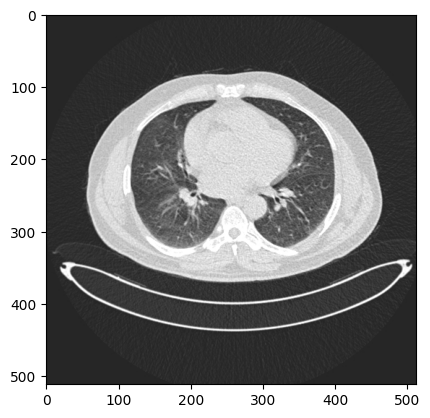

In [27]:
predict(enc_model,Image.open(r"Dataset\Bengin cases\Bengin case (66).jpg"))